In [1]:
import sqlite3 as sql
import pandas as pd
import os

In [2]:
class SQLiteDB:
    
    def __init__(self, db):
        self.db = db
        self.conn = None
        
    def connect(self):
        """Create a database connection to the SQLite database."""
        try:
            self.conn = sql.connect(self.db)
        except sql.Error as e:
            print(e)
            
    def create_table(self, create_table_sql):
        """Create a table from the create_table_sql statement."""
        try:
            c = self.conn.cursor()
            c.execute(create_table_sql)
            print("Table created successfully")
        except sql.Error as e:
            print(e)
    
    def delete_table(self, table_name):
        """Delete a table from the database."""
        try:
            c = self.conn.cursor()
            c.execute(f"DROP TABLE IF EXISTS {table_name}")
            print(f"Table {table_name} deleted successfully")
        except sql.Error as e:
            print(e)
    
    def show_tables(self):
        """Display all tables in the database."""
        query = "SELECT name FROM sqlite_master WHERE type='table';"
        try:
            c = self.conn.cursor()
            c.execute(query)
            tables = c.fetchall()
            print("Tables in the database:")
            for table in tables:
                print(table[0])
        except sql.Error as e:
            print(e)
    
    def close(self):
        """Close the database connection."""
        if self.conn:
            self.conn.close()
            
    def insert_csv_data(self, csv_file):
        """
        Add data from a CSV file to a table in the database.
        """
        # Derive table name from the CSV file name (excluding the extension)
        table_name = os.path.splitext(os.path.basename(csv_file))[0]
        
        df = pd.read_csv(csv_file)

        if table_name == 'patients':
        # Insert the data into the table, create the table if it doesn't exist for patients since it has a primary key
            df.to_sql(table_name, self.conn, if_exists='append', index=False)

            print(f"Data from {csv_file} added to {table_name} table.")
        
        # replace data if it exists for BP csv files since there is no primary key?
        else:
            df.to_sql(table_name, self.conn, if_exists='replace', index=False)

            print(f"Data from {csv_file} added to {table_name} table.")

In [3]:
#create DashMed db and patients table

dashmed = SQLiteDB('DashMed.db')

patients = """
CREATE TABLE IF NOT EXISTS patients (
  PatientId integer PRIMARY KEY,
  FirstName text NOT NULL,
  LastName text NOT NULL,
  Address text NOT NULL,
  Phone text NOT NULL,
  Sex text NOT NULL,
  Birthdate date NOT NULL,
  Age integer NOT NULL,
  RelatedPatients text,
  MedicalHistory text,
  Medication text  
);
"""

dashmed.connect()
dashmed.delete_table('patients')
dashmed.create_table(patients)
dashmed.insert_csv_data('patient_data/patients.csv')
dashmed.show_tables()
dashmed.close()

Table patients deleted successfully
Table created successfully
Data from patient_data/patients.csv added to patients table.
Tables in the database:
30110_BP
23989_BP
33764_BP
30111_BP
40284_BP
54658_BP
57180_BP
97021_BP
patients


In [14]:
# Inserting BP Tables

for filename in os.listdir('patient_data/patient_bp/'):
    if filename.endswith(".csv"):
        csv_file = os.path.join('patient_data/patient_bp/', filename)
        dashmed.connect()
        dashmed.insert_csv_data(csv_file)
        dashmed.close()

dashmed.connect()    
dashmed.show_tables()
dashmed.close()

Data from patient_data/patient_bp/30110_BP.csv added to 30110_BP table.
Data from patient_data/patient_bp/23989_BP.csv added to 23989_BP table.
Data from patient_data/patient_bp/33764_BP.csv added to 33764_BP table.
Data from patient_data/patient_bp/30111_BP.csv added to 30111_BP table.
Data from patient_data/patient_bp/40284_BP.csv added to 40284_BP table.
Data from patient_data/patient_bp/54658_BP.csv added to 54658_BP table.
Data from patient_data/patient_bp/57180_BP.csv added to 57180_BP table.
Data from patient_data/patient_bp/97021_BP.csv added to 97021_BP table.
Tables in the database:
patients
30110_BP
23989_BP
33764_BP
30111_BP
40284_BP
54658_BP
57180_BP
97021_BP


In [5]:
class PatientSummary():
    """ Summary class to retrieve patient data from an input patient ID. """
    
    def __init__(self, db, PatientId):
        self.db = db
        self.PatientId = PatientId

    def patient_exists(self):
        """ Check if the patient ID number does exist in the database. """

        query = 'SELECT COUNT(*) FROM patients WHERE PatientId = ?'  # Placeholder added

        try:
            self.db.connect()
            cursor = self.db.conn.cursor()
            cursor.execute(query, (self.PatientId,))  # Correctly binding the patient ID
            result = cursor.fetchone()
            return result[0] > 0
        
        except sql.Error as e:
            print(e)
            return False

        finally:
            self.db.close()

    def getdata(self):
        """ Return the row containing the patient information as a list. """
        if not self.patient_exists():
            print("Patient ID not valid. Please input valid patient ID.")
            return

        query = 'SELECT * FROM patients WHERE PatientId = ?'  # Placeholder added

        try:
            self.db.connect()
            cursor = self.db.conn.cursor()
            cursor.execute(query, (self.PatientId,))  # Correctly binding the patient ID
            patient_data = [n for n in cursor.fetchone()]
            
            return patient_data
        
        except sql.Error as e:
            print(e)

        finally:
            self.db.close()


In [27]:
class Dashboard:

    def __init__(self, summary):
        """ Initialize with a Summary object """
        self.summary = summary

    def display_dash(self):
        """ Display the patient data in a simple dashboard format. """
        patient_data = self.summary.getdata()
        
        PatientId, FirstName, LastName, Address, Phone, Sex, Birthdate, Age, RelatedPatients, MedicalHistory, Medication = patient_data

        # Simple dashboard display
        print("Patient Dashboard")
        print("-------------------------------------")
        print(f"Patient ID: {PatientId}")
        print(f"First name: {FirstName}")
        print(f"Last name: {LastName}")
        print(f"Address: {Address}")
        print(f"Phone: {Phone}")
        print(f"Sex: {Sex}")
        print(f"Birthdate: {Birthdate}")
        print(f"Age: {Age}")
        print(f"Related patients: {RelatedPatients}")
        print(f"Medical history: {MedicalHistory}")
        print(f"Medication: {Medication}")
        print("-------------------------------------")


In [29]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

class BPSummary:
    """ BPSummary class to retrieve blood pressure data from database and plot graph. """
    def __init__(self, db, PatientId):
        self.db = db
        self.PatientId = PatientId
        self.table = f'"{PatientId}_BP"'

    def table_exists(self):
        """ Check if the BP table for the patient exists in the database. """
        
        query = "SELECT * FROM sqlite_master WHERE type='table' AND name=?;"

        try:
            self.db.connect()
            cursor = self.db.conn.cursor()
            cursor.execute(query, (self.PatientId + "_BP",))
            return cursor.fetchone() is not None
        
        except sql.Error as e:
            print(e)
            return False

        finally:
            self.db.close()

    def get_bp_data(self):
        """ Fetch the BP data for the patient from the database. """
        if not self.table_exists():
            print(f"No BP data table found for patient ID {self.PatientId}.")
            return None
        
        query = f'SELECT * FROM {self.table};'

        try:
            self.db.connect()
            cursor = self.db.conn.cursor()
            cursor.execute(query) 
            columns = [desc[0] for desc in cursor.description] # Fetch the column names
            bp_data = cursor.fetchall()

            df = pd.DataFrame(bp_data, columns=columns)
            return df
        
        except sql.Error as e:
            print(e)

        finally:
            self.db.close()

    def plot(self):
        """ Plot the BP data for the patient. """
        bp_data = self.get_bp_data()
        if bp_data is not None:
            # Convert the Date column to datetime objects for plotting
            bp_data['Date'] = pd.to_datetime(bp_data['Date'])
            
            plt.figure(figsize=(14, 7))
            plt.plot(bp_data['Date'], bp_data['Resting Heart Rate'], label='Resting Heart Rate')
            plt.plot(bp_data['Date'], bp_data['Systolic Pressure'], label='Systolic Pressure')
            plt.plot(bp_data['Date'], bp_data['Diastolic Pressure'], label='Diastolic Pressure')

            plt.title(f'Blood Pressure Summary for Patient {self.PatientId}')
            plt.xlabel('Date')
            plt.ylabel('Values')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()


Patient Dashboard
-------------------------------------
Patient ID: 23989
First name: Edward
Last name: Johnson
Address: 101 Maple Ave
Phone: (555) 123-4567
Sex: M
Birthdate: 1989-01-24
Age: 34
Related patients: Diana Smith
Medical history: Hypertension
Medication: Lisinopril
-------------------------------------


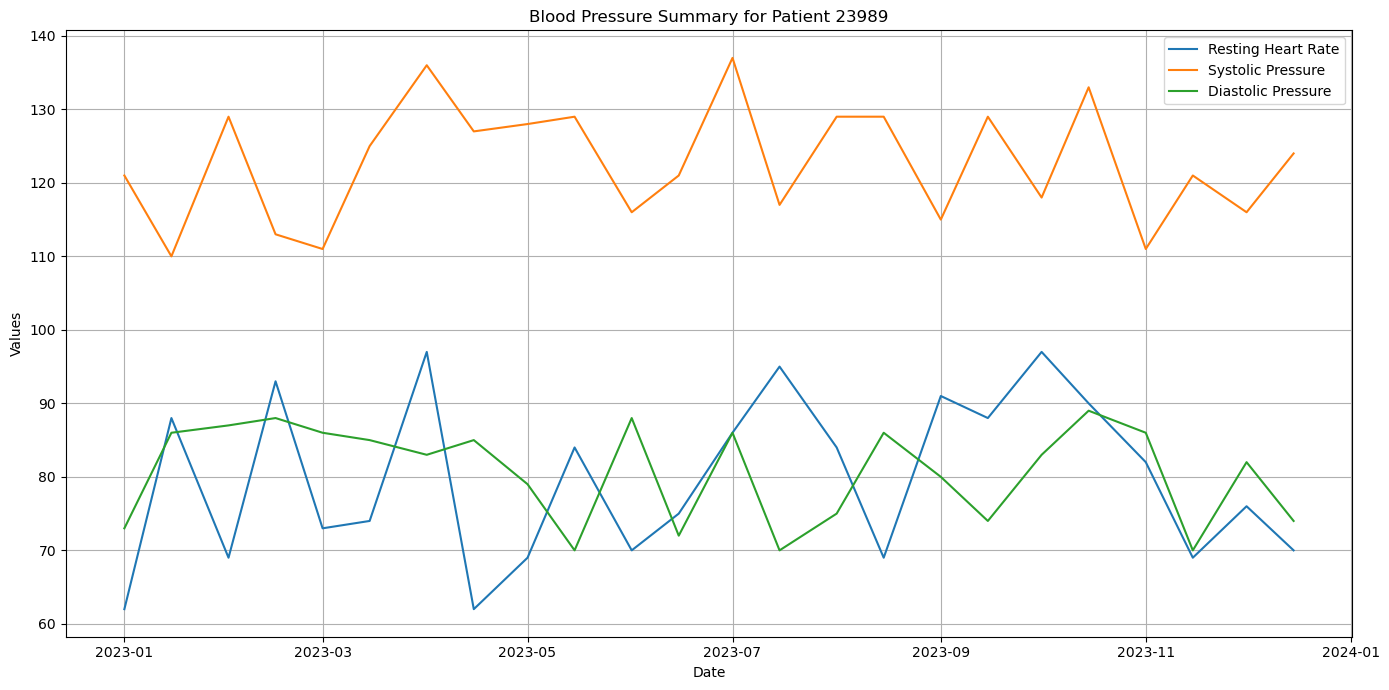

In [30]:
# Testing for the dashboard
id = input('input an ID')
id_dash = Dashboard(PatientSummary(dashmed, id))
id_dash.display_dash()

# Testing for the BP graph
id_bp = BPSummary(dashmed, id)
id_bp.plot()

In [2]:
import os
print(os.getcwd())  

c:\Users\matta\Documents\MDS Files\BLOCK 3\Data 533\Project\DashMed


In [2]:
import os
from dashmed.database.sqlite import SQLiteDB
from dashmed.database.role import *

def initialize_database():
    """Check if 'DashMed.db' exists and initialize it if not."""
    db_path = "DashMed.db"

    if os.path.exists(db_path):
        print(f"'{db_path}' already exists. Database initialization skipped.")
    else:
        db = SQLiteDB(db_path)
        db.initialize_db()
        print(f"Database '{db_path}' initialized.")
        
        user = Admin('Admin', 0) #check to make sure an administrator is trying to execute table generation.
        
        print("Inserting Toy Data")
        db.connect()
        db.insert_csv_data(user, 'patient_data/patients.csv')
        db.close()
        
        for filename in os.listdir('patient_data/patient_bp/'):
            if filename.endswith(".csv"):
                csv_file = os.path.join('patient_data/patient_bp/', filename)
                db.connect()
                db.insert_csv_data(user, csv_file)
                db.close()

        db.connect()
        db.show_tables(user)
        db.close()
        
        print('Complete!')
        
if __name__ == "__main__":
    initialize_database()

Database initialized.
Database 'DashMed.db' initialized.
Inserting Toy Data
Data from patient_data/patients.csv added to patients table.
Data from patient_data/patient_bp/23989_BP.csv added to 23989_BP table.
Data from patient_data/patient_bp/30110_BP.csv added to 30110_BP table.
Data from patient_data/patient_bp/30111_BP.csv added to 30111_BP table.
Data from patient_data/patient_bp/33764_BP.csv added to 33764_BP table.
Data from patient_data/patient_bp/40284_BP.csv added to 40284_BP table.
Data from patient_data/patient_bp/54658_BP.csv added to 54658_BP table.
Data from patient_data/patient_bp/57180_BP.csv added to 57180_BP table.
Data from patient_data/patient_bp/97021_BP.csv added to 97021_BP table.
Tables in the database:
patients
users
sqlite_sequence
23989_BP
30110_BP
30111_BP
33764_BP
40284_BP
54658_BP
57180_BP
97021_BP
Complete!


In [2]:
from dashmed.database.sqlite import SQLiteDB
from dashmed.database.role import *

print('Welcome to Dashmed.')

while True:
        print("\n1. Create new user\n2. Login to existing user\n3. Exit")
        choice = input(print("Enter your choice: "))
        
        if choice == '1':
            user = create_user()
            user.display()
            user.add_to_database(db = SQLiteDB("DashMed.db"))

        elif choice == '2':
            name = input("Enter your name: ")
            password = getpass.getpass("Enter your password: ")
            db = SQLiteDB("DashMed.db")
            user = db.authenticate_user(name, password)
            
            if user:
                while True:
                    print("\n1. View Patient Summary\n2. View Patient BP data\n3. Add new Data\n4. Exit")
                    choice = input(print("Enter your choice: "))

                    if choice == '1':
                        pass
                    
                    elif choice == '2':
                        pass
                    
                    elif choice == '3':
                        path_to_csv = input(print('Enter the Path to your CSV file'))
                        
                        try:
                            db = SQLiteDB('Dashmed.db')
                            db.conn()
                    
                    elif choice == '4':
                        print("Logging Out")
                        break
                    
                    else:
                        print('Invalid input.')
                    
        elif choice == '3':
            print("Exiting Dashmed.")
            break
        
        else:
            print('Invalid Input.')

Welcome to Dashmed.

1. Create new user
2. Login to existing user
3. Exit
(6, 'matth', 22, 'Admin', '123')
Login successful for matth.

1. View Patient Summary
2. View Patient BP data
3. Add new Data
4. Exit
Enter your choice: 

1. View Patient Summary
2. View Patient BP data
3. Add new Data
4. Exit
Enter your choice: 
Invalid input.

1. View Patient Summary
2. View Patient BP data
3. Add new Data
4. Exit
Enter your choice: 
Logging Out

1. Create new user
2. Login to existing user
3. Exit
Exiting Dashmed.
